In [1]:
import sklearn.datasets
from sklearn.cross_validation import train_test_split
import re
import tensorflow as tf
from sklearn import metrics
import numpy as np
import collections
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
def clearstring(string):
    string = re.sub('[^A-Za-z ]+', '', string)
    string = string.split('\n')
    string = [y.strip() for y in filter(None, string)]
    string = (' '.join(string)).lower()
    return ' '.join([y.strip() for y in string.split()])

def separate_dataset(trainset):
    datastring = []
    datatarget = []
    for i in range(len(trainset.data)):
        data_ = trainset.data[i].split('\n')
        data_ = list(filter(None, data_))
        for n in range(len(data_)):
            data_[n] = clearstring(data_[n])
        datastring += data_
        for n in range(len(data_)):
            datatarget.append(trainset.target[i])
    return datastring, datatarget

def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    count.extend(collections.Counter(words).most_common(n_words))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK=3):
    X = np.zeros((len(corpus),maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            try:
                X[i,-1 - no]=dic[k]
            except Exception as e:
                X[i,-1 - no]=UNK
    return X

In [14]:
dataset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
dataset.data, dataset.target = separate_dataset(dataset)
_,dataset.data,_,dataset.target=train_test_split(dataset.data,dataset.target,test_size = 0.03)
len(dataset.data)

12505

In [15]:
concat = ' '.join(dataset.data).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 13353
Most common words [('i', 20247), ('feel', 8632), ('and', 7325), ('to', 6926), ('the', 6379), ('a', 4882)]
Sample data [4, 16, 11, 109, 49, 930, 39, 33, 42, 362] ['i', 'like', 'that', 'these', 'are', 'small', 'because', 'you', 'can', 'enjoy']


In [10]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [16]:
def get_one_triplet(input_data, input_labels, n_labels):
    index = np.random.choice(n_labels, 2, replace=False)
    label_positive = index[0]
    label_negative = index[1]

    indexes = np.where(input_labels == index[0])[0]
    np.random.shuffle(indexes)

    data_anchor = input_data[indexes[0], :]
    data_positive = input_data[indexes[1], :]

    indexes = np.where(input_labels == index[1])[0]
    np.random.shuffle(indexes)
    data_negative = input_data[indexes[0], :]

    return data_anchor, data_positive, data_negative, label_positive, label_positive, label_negative

def compute_euclidean_distance(x, y):
    d = tf.square(tf.subtract(x, y))
    return tf.sqrt(tf.reduce_sum(d))

def compute_triplet_loss(anchor_feature, positive_feature, negative_feature, margin=0.01):
    d_p_squared = tf.square(compute_euclidean_distance(anchor_feature, positive_feature))
    d_n_squared = tf.square(compute_euclidean_distance(anchor_feature, negative_feature))
    loss = tf.maximum(0., d_p_squared - d_n_squared + margin)
    return tf.reduce_mean(loss), tf.reduce_mean(d_p_squared), tf.reduce_mean(d_n_squared)

In [18]:
class Model:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, dimension_output,margin=0.2):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer,reuse=reuse)
        
        def rnn(embedded,reuse=False):
            with tf.variable_scope('model', reuse=reuse):
                rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
                outputs, _ = tf.nn.dynamic_rnn(rnn_cells, embedded, dtype = tf.float32)
                W = tf.get_variable('w',shape=(size_layer, dimension_output),initializer=tf.orthogonal_initializer())
                b = tf.get_variable('b',shape=(dimension_output),initializer=tf.zeros_initializer())
                return tf.matmul(outputs[:, -1], W) + b
            
        self.ANCHOR = tf.placeholder(tf.int32, [None, None])
        self.POSITIVE = tf.placeholder(tf.int32, [None, None])
        self.NEGATIVE = tf.placeholder(tf.int32, [None, None])
        self.Y_ANCHOR = tf.placeholder(tf.int32, [None])
        self.Y_POSITIVE = tf.placeholder(tf.int32, [None])
        self.Y_NEGATIVE = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], -1, 1))
        anchor_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.ANCHOR)
        positive_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.POSITIVE)
        negative_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.NEGATIVE)
        self.output_anchor = rnn(anchor_embedded,False)
        self.output_positive = rnn(positive_embedded,True)
        self.output_negative = rnn(negative_embedded,True)
        self.cost, positives, negatives = compute_triplet_loss(self.output_anchor, 
                                                          self.output_positive, 
                                                          self.output_negative)
        self.optimizer = tf.train.GradientDescentOptimizer(1e-4).minimize(self.cost)

In [20]:
size_layer = 256
num_layers = 2
embedded_size = 128
dimension_output = len(dataset.target_names)
maxlen = 50
batch_size = 128

In [21]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(size_layer,num_layers,embedded_size,len(dictionary),32)
sess.run(tf.global_variables_initializer())

In [23]:
X = str_idx(dataset.data,dictionary,maxlen)
Y = dataset.target

In [24]:
for i in range(50):
    lasttime = time.time()
    batch_anchor = np.zeros((batch_size,maxlen))
    batch_positive = np.zeros((batch_size,maxlen))
    batch_negative = np.zeros((batch_size,maxlen))
    batch_y_anchor = np.zeros((batch_size))
    batch_y_positive = np.zeros((batch_size))
    batch_y_negative = np.zeros((batch_size))
    for k in range(batch_size):
        batch_anchor[k], batch_positive[k], batch_negative[k], batch_y_anchor[k], batch_y_positive[k], batch_y_negative[k] = get_one_triplet(X, Y, dimension_output)
    loss, _ = sess.run([model.cost,model.optimizer],
                       feed_dict={model.ANCHOR:batch_anchor,
                                  model.POSITIVE:batch_positive,
                                  model.NEGATIVE:batch_negative,
                                  model.Y_ANCHOR:batch_y_anchor,
                                  model.Y_POSITIVE:batch_y_positive,
                                  model.Y_NEGATIVE:batch_y_negative})
    print('epoch: %d, loss: %f'%(i+1,loss))

epoch: 1, loss: 52.063587
epoch: 2, loss: 34.362415
epoch: 3, loss: 92.985100
epoch: 4, loss: 17.065908
epoch: 5, loss: 41.615467
epoch: 6, loss: 0.000000
epoch: 7, loss: 0.000000
epoch: 8, loss: 21.904287
epoch: 9, loss: 0.000000
epoch: 10, loss: 0.000000
epoch: 11, loss: 0.000000
epoch: 12, loss: 33.314075
epoch: 13, loss: 114.887932
epoch: 14, loss: 0.000000
epoch: 15, loss: 40.939686
epoch: 16, loss: 0.000000
epoch: 17, loss: 0.000000
epoch: 18, loss: 0.000000
epoch: 19, loss: 0.000000
epoch: 20, loss: 9.772329
epoch: 21, loss: 41.573231
epoch: 22, loss: 0.000000
epoch: 23, loss: 11.069448
epoch: 24, loss: 26.663565
epoch: 25, loss: 0.000000
epoch: 26, loss: 33.510365
epoch: 27, loss: 0.000000
epoch: 28, loss: 41.399036
epoch: 29, loss: 0.000000
epoch: 30, loss: 0.000000
epoch: 31, loss: 8.973501
epoch: 32, loss: 0.000000
epoch: 33, loss: 0.000000
epoch: 34, loss: 0.000000
epoch: 35, loss: 54.119862
epoch: 36, loss: 3.187856
epoch: 37, loss: 72.178337
epoch: 38, loss: 0.000000
epoc

In [26]:
logits_test = sess.run(model.output_positive,feed_dict={model.POSITIVE:X})

In [28]:
from scipy.spatial.distance import cdist
label_test = []
for i in range(logits_test.shape[0]):
    label_test.append(Y[np.argsort(cdist(logits_test, [logits_test[i,:]], 'cosine').ravel())[0]])
print(metrics.classification_report(Y, label_test, target_names = dataset.target_names))

             precision    recall  f1-score   support

      anger       1.00      1.00      1.00      1706
       fear       1.00      1.00      1.00      1482
        joy       1.00      1.00      1.00      4179
       love       1.00      1.00      1.00      1103
    sadness       1.00      1.00      1.00      3589
   surprise       1.00      1.00      1.00       446

avg / total       1.00      1.00      1.00     12505



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

In [32]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(perplexity=200, n_jobs=4)
manifold_emotions = tsne.fit_transform(logits_test)

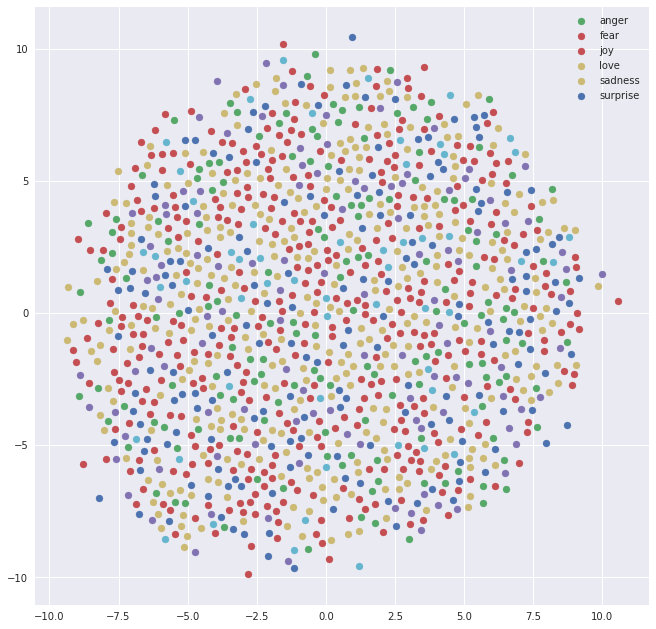

In [42]:
ax_min = np.min(logits_test,0)
ax_max = np.max(logits_test,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(11,11))
ax = plt.subplot(111)
shown_images = np.array([[1., 1.]])
colors = sns.color_palette(n_colors=len(dataset.target_names))
for i in range(manifold_emotions.shape[0]):
    dist = np.sum((manifold_emotions[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [manifold_emotions[i]]]
    plt.scatter(manifold_emotions[i,0],manifold_emotions[i,1],c=colors[Y[i]])
plt.legend(dataset.target_names)
plt.show()